# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import *
from sklearn.model_selection import train_test_split
from common.optimizer import *
import pickle
import sklearn.preprocessing as sp
from model import *

## データを読む1

In [20]:
raw_data = np.load("../1_data/train_data.npy")
raw_label = np.load("../1_data/train_label.npy")
raw_data = raw_data[:raw_data.shape[0]//1000*1000]
raw_label = raw_label[:raw_label.shape[0]//1000*1000]
print("raw_data.shape=", raw_data.shape)
print("raw_label.shape=", raw_label.shape)
# 正規化
raw_data = (raw_data - raw_data.min()) / raw_data.max()
raw_data = raw_data.astype('float32')

raw_data.shape= (3000, 1, 28, 28)
raw_label.shape= (3000, 15)


In [21]:
train_data = np.load("../1_data/integ_data7.npy")
train_label = np.load("../1_data/integ_label7.npy")
train_data = train_data[:train_data.shape[0]//1000*1000]
train_label = train_label[:train_label.shape[0]//1000*1000]
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

train_data.shape= (30000, 1, 28, 28)
train_label.shape= (30000, 15)


In [22]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (30000, 784)


## trainとtestに分割する

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label,test_size=0.3, random_state=1234, shuffle=True)

print(X_train.shape, X_test.shape)

(21000, 784) (9000, 784)


In [24]:
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
train_data = train_data.reshape(-1,1, 28,28)

In [25]:
print(X_train.shape, X_test.shape)

(21000, 1, 28, 28) (9000, 1, 28, 28)


## 学習

In [44]:
def save_pickle(i):
    with open("katakana_mTfs_d70_ep"+str(i)+"_w.pickle", "wb") as f:
        pickle.dump(tnet.params, f)

    c={
        "Batch_c1":[tnet.layers["Batch_c1"].moving_mean,tnet.layers["Batch_c1"].moving_var],
        # "Batch_c2":[tnet.layers["Batch_c2"].moving_mean,tnet.layers["Batch_c2"].moving_var],
        "Batch_c3":[tnet.layers["Batch_c3"].moving_mean,tnet.layers["Batch_c3"].moving_var],
        # "Batch_c4":[tnet.layers["Batch_c4"].moving_mean,tnet.layers["Batch_c4"].moving_var],
        "Batch_c5":[tnet.layers["Batch_c5"].moving_mean,tnet.layers["Batch_c5"].moving_var],
        "Batch_a1":[tnet.layers["Batch_a1"].moving_mean,tnet.layers["Batch_a1"].moving_var]
    }
    with open("katakana_mTfs_d70_ep"+str(i)+"_c.pickle", "wb") as f:
        pickle.dump(c, f)

In [27]:
def calc_loss_acc(d,l,model): 
    data_size = len(d)
    batch_size = 1000
    minibatch_num = np.ceil( data_size / batch_size).astype(int) 
    li_loss = []
    li_accuracy = []
    li_num = []
    index = np.arange(data_size)
    
    for mn in range(minibatch_num):
        # print(mn)
        mask = index[batch_size*mn:batch_size*(mn+1)]        
        data = d[mask]
        label = l[mask]
        y_pre=model.predict(data,train_flg=False)
        loss = model.last_layer.forward(y_pre,label)
        y_pre= np.argmax(y_pre,axis=1)
        label= np.argmax(label,axis=1)
        accuracy = np.sum(y_pre==label)/data.shape[0]
        # print(loss, accuracy)
        
        li_loss.append(loss)
        li_accuracy.append(accuracy)
        li_num.append(len(data))

    ave_loss = np.dot(li_loss, li_num) / np.sum(li_num)
    print('loss:', ave_loss)
    ave_accuracy = np.dot(li_accuracy, li_num) / np.sum(li_num)
    print('accuracy:', ave_accuracy)
    return ave_loss,ave_accuracy

In [32]:
tnet = TfsConvNet(input_dim=(1, 28, 28), hidden_size=100, output_size=15, weight_init_std=0.01)


In [33]:
for l in tnet.layers.keys():
    print(l)
for p in tnet.params.keys():
    print(p+"    \t"+str(tnet.params[p].shape))
print()

Conv1
Batch_c1
ReLU1
Pool1
Conv3
Batch_c3
ReLU3
Pool2
Conv5
Batch_c5
ReLU5
Affine1
Batch_a1
Affine2

W_c1    	(32, 1, 3, 3)
b_c1    	(32,)
gamma_c1    	(32,)
beta_c1    	(32,)
W_c3    	(64, 32, 3, 3)
b_c3    	(64,)
gamma_c3    	(64,)
beta_c3    	(64,)
W_c5    	(64, 64, 3, 3)
b_c5    	(64,)
gamma_c5    	(64,)
beta_c5    	(64,)
W_a1    	(1600, 100)
b_a1    	(100,)
gamma_a1    	(100,)
beta_a1    	(100,)
W_a2    	(100, 15)
b_a2    	(15,)


In [34]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
optimizer = Adam()
epoch=0

In [36]:
# epochs = 10
batch_size = 1000

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)
# 2層NNのオブジェクト生成


epochs=10
while epoch<epochs:
    
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]
    
        # ミニバッチの生成
        x_ = X_train[mask]
        y_ = y_train[mask]
        
        # 勾配の計算
        grads = tnet.gradient(x_, y_)

        # パラメータの更新
        optimizer.update(tnet.params, grads)

    ## 学習経過の記録
    
  
    # 訓練データにおけるloss,acc
    print("###  train  ###")
    loss,acc=calc_loss_acc(X_train,y_train,tnet)
    train_loss.append(loss)
    train_accuracy.append(acc)
    print()
    # テストデータにおけるloss,acc
    print("###  test  ###")
    loss,acc=calc_loss_acc(X_test,y_test,tnet)
    test_loss.append(loss)
    test_accuracy.append(acc)

    
    # save_pickle(epoch)
    
    if test_accuracy[-1]==1:
        break
    epoch+=1

epoch=5
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 0.03706128651223221
accuracy: 0.9999047619047619

###  test  ###
loss: 0.04894745361242961
accuracy: 0.9973333333333333
epoch=6
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 0.03360810556306863
accuracy: 1.0

###  test  ###
loss: 0.046386756864268776
accuracy: 0.998
epoch=7
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 0.018265662115968737
accuracy: 1.0

###  test  ###
loss: 0.0291746621704011
accuracy: 0.9981111111111111
epoch=8
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 0.014749201000

In [45]:
save_pickle(epoch-1)

In [ ]:
calc_loss_acc(X_train,y_train,tnet)

In [ ]:
plt.plot(test_loss,label="test")
plt.plot(train_loss,label="train")
plt.legend()
plt.ylim([0,0.2])

In [ ]:
plt.plot(test_accuracy,label="test")
plt.plot(train_accuracy,label="train")
plt.legend()
plt.ylim([0.95,1])

## 学習済みモデルの復元

In [46]:
with open("katakana_mTfs_d70_ep9_w.pickle", "rb") as f:
    w=pickle.load(f)
with open("katakana_mTfs_d70_ep9_c.pickle", "rb") as f:
    c=pickle.load(f)

In [47]:
tnet2=TfsConvNet(input_dim=(1, 28, 28),param=w,const=c)

In [48]:
tnet2.layers["Batch_c1"].moving_mean

array([ 0.08111119,  0.00194493,  0.01839371,  0.05980254,  0.02373021,
        0.00427221,  0.03977364,  0.02689135,  0.00602421,  0.03666823,
        0.01637456,  0.00475368,  0.02127838,  0.00391997,  0.00314332,
       -0.01683814,  0.01010332, -0.03003121, -0.01890055,  0.00879357,
       -0.01975108,  0.0219052 ,  0.06646518, -0.00017839,  0.02796989,
        0.00692618,  0.01119468,  0.00215044,  0.00880133,  0.01295128,
        0.07349581, -0.06492941])

In [50]:
def _check_fail(x,y,t,cnt):
    kana=["a","i","u","e","o","ka","ki","ku","ke","ko","sa","si","su","se","so"]
    for _x,_y,_t in zip(x,y,t):
        __t,__y=np.argmax(_t),np.argmax(_y)
        if __y!=__t:
            cnt+=1
            print("cnt:",cnt,"label:",kana[__t],"pre:",kana[__y])
            plt.imshow(_x[0,:,:],cmap="gray")
            plt.show()
    return cnt

def check_fail(x,t,m):
    index = np.arange(x.shape[0])
    cnt=0
    for i in range(x.shape[0]//100):
        print("No.",i*1000,"~")
        mask=index[i*1000:(i+1)*1000]
        _x=x[mask]
        _t=t[mask]
        _pre_x=m.predict(_x,train_flg=False)
        cnt=_check_fail(_x,_pre_x,_t,cnt)
        if cnt>100:
            break

No. 0 ~
No. 1000 ~
No. 2000 ~
No. 3000 ~
cnt: 1 label: ku pre: ka


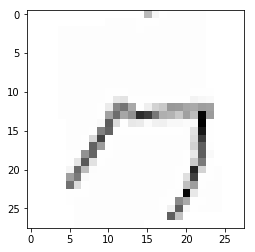

No. 4000 ~
cnt: 2 label: ku pre: ka


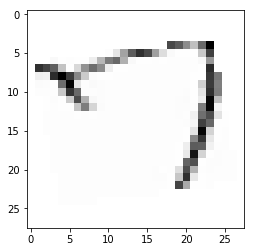

cnt: 3 label: su pre: ku


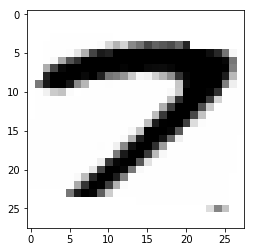

No. 5000 ~
cnt: 4 label: su pre: ku


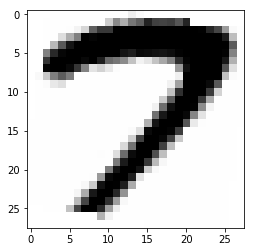

cnt: 5 label: se pre: ka


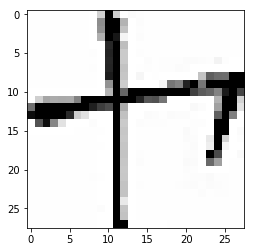

No. 6000 ~
cnt: 6 label: ke pre: ku


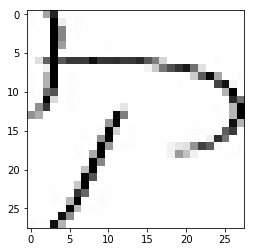

cnt: 7 label: se pre: ka


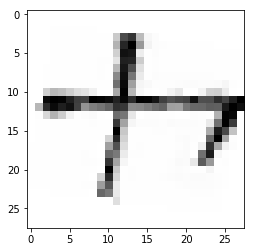

No. 7000 ~
No. 8000 ~
No. 9000 ~


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [51]:
check_fail(X_test,y_test,tnet2)